#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## 1. Подготовка

### 1.1 Установка и импорт библиотек

In [1]:
# Установим необходимые библиотеки

!pip -q install scikit-learn

In [5]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from catboost import CatBoostRegressor

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose

import os
import requests

import warnings

In [2]:
# Игрорируем предупреждения

warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
# Определим константы

RANDOM_STATE = 42
TEST_SIZE = 0.1

### 1.2 Чтение и знакомство с данными

In [7]:
# Скачаем датасет

base_url = "https://huggingface.co/datasets/onejetpilot/taxi/resolve/main/"

filename = "taxi.csv"
local_path = filename

if not os.path.exists(local_path):
    print(f"Файл {filename} не найден — начинаю скачивание...")

    file_url = base_url + filename
    response = requests.get(file_url, stream=True)

    if response.status_code == 200:
        with open(local_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Файл успешно скачан: {local_path}")
    else:
        print(f"Ошибка при скачивании: {response.status_code}")
else:
    print(f"Файл {filename} уже есть локально, загрузка пропущена.")

Файл taxi.csv уже есть локально, загрузка пропущена.


In [9]:
# Создадим датафрейм из таблицы

data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [10]:
# Сортируем индексы и проведем ресемплирование по 1 часу

data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [11]:
# Проверим ряд на монотонность и дубликаты

is_unique = data.index.is_unique
is_monotonic = data.index.is_monotonic_increasing

if is_unique and is_monotonic:
    print('Индексы уникальны и идут по времени правильно')
elif not is_unique:
    print('Есть дубликаты временных меток')
elif not is_monotonic:
    print('Ряд по времени не отсортирован')

Индексы уникальны и идут по времени правильно


In [12]:
# Проверим размер получившегося датасета

data.shape

(4416, 1)

In [13]:
# Посмотрим на датасет

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [14]:
# Создадим функцию для просмотра общей информации о датасете

def overview_data(data):
    """
    Выводит информацию о DataFrame - типы данных, 
    статистику, количество пропусков и дубликатов

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, для которой требуется провести обзор

    Возвращает
    ----------
    None
        Функция выводит информацию
    """
    
    
    d = '-' * 50
    
    print(d)
    print('Инфо')
    print(d)
    print(data.info())
    print('\n')
    
    print(d)
    print('Статистика')
    print(d)
    print(data.describe())
    print('\n')
    
    print(d)
    print('Пропуски в количестве заказов')
    print(d)
    print(data.isna().sum())
    print('\n')
    
    
    print(d)
    print('Дубликаты количества заказов')
    print(d)
    print(data.duplicated().sum())
    print('\n')

    print(d)
    print('Нулевые значения в количестве заказов')
    print(d)
    print((data == 0).sum())
    print('\n')

In [15]:
# Выведем информацию о датасете

overview_data(data)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 198.0 KB
None


--------------------------------------------------
Статистика
--------------------------------------------------
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


--------------------------------------------------
Пропуски в количестве заказов
--------------------------------------------------
num_orders    0
dtype: int64


--------------------------------------------------
Дубликаты количества заказов
--------------------------------------------------

In [18]:
# Посмотрим что получилось

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод

- Загрузили данные и посмотрели на них:

- В столбце с количеством заказов:
    - пропусков нет
    - есть нулевые значения, что ожидаемо т.к. за час может прото не быть заказов
    - дубликаты есть, что также возможно

- В столбце с временными метками:
    - метки идут по порядку
    - повторяющихся значений нет


## 2. Анализ

### 2.1. Анализ числовых признаков

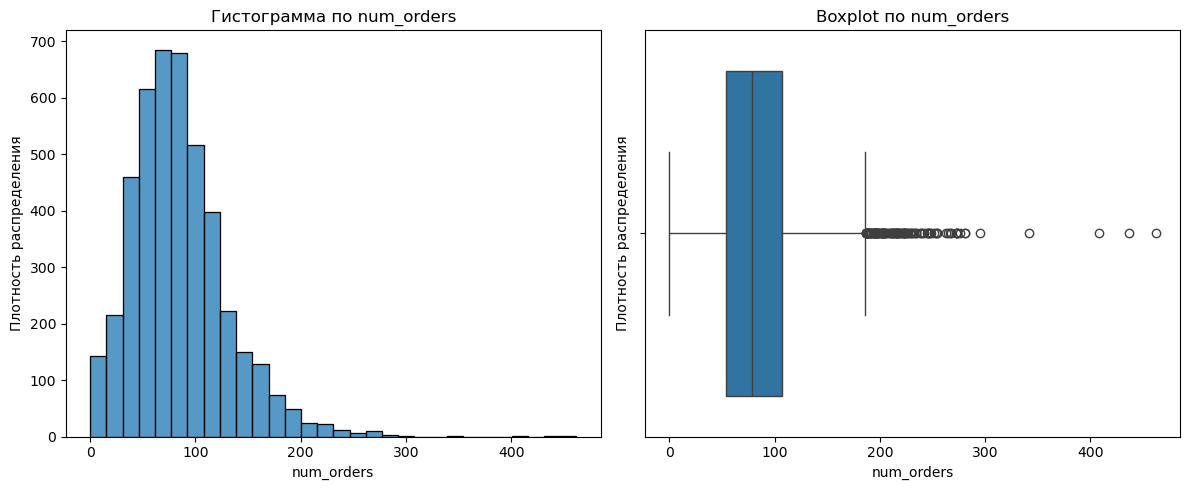

In [19]:
# Визуализируем num_orders

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['num_orders'], kde=False, bins=30)
plt.title("Гистограмма по num_orders")
plt.xlabel("num_orders")
plt.ylabel("Плотность распределения")

plt.subplot(1, 2, 2)
sns.boxplot(x=data['num_orders'])
plt.title("Boxplot по num_orders")
plt.xlabel("num_orders")
plt.ylabel("Плотность распределения")

plt.tight_layout()
plt.show()

- num_orders - выбросы присутствуют, но они не аномальные, а, скорее всего, отражают реальные пики спроса. Исключать их не нужно. Целевой признак.

### 2.2. Автокорреляции

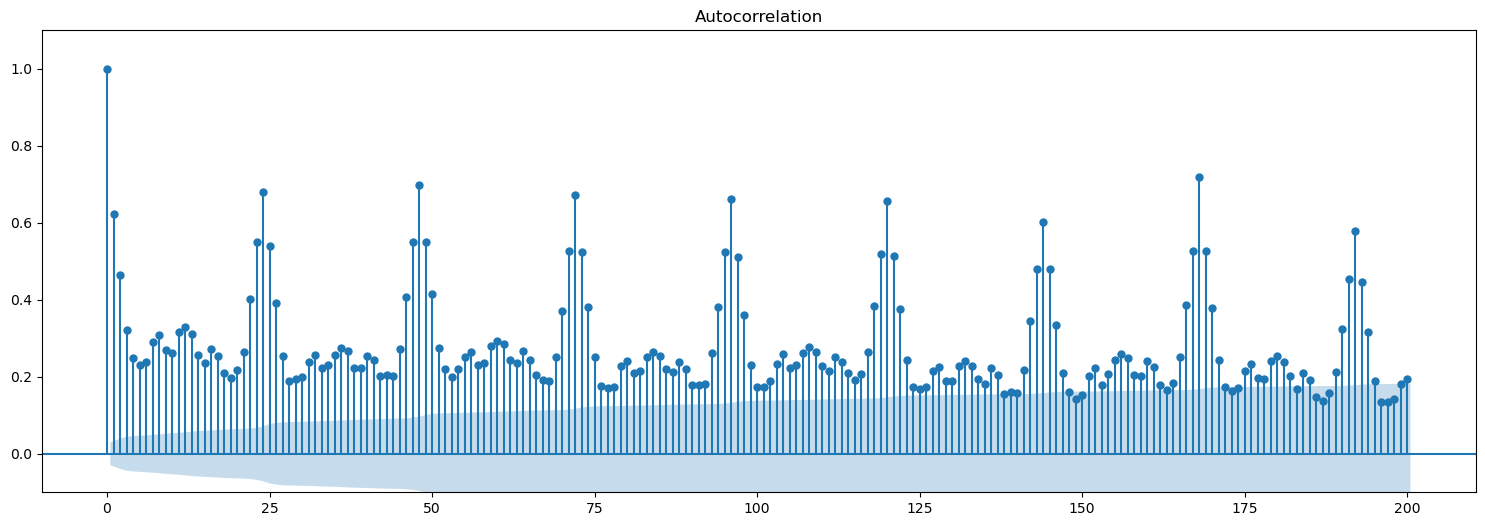

In [20]:
# Автокорреляция полная

ts = data['num_orders']

fig = tsaplots.plot_acf(ts,lags=200)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

Что мы можем сказать по графику

- Явные циклы каждые 24 лага — это суточная сезонность
- Явные циклы каждые 168 лагов — это недельная сезонность

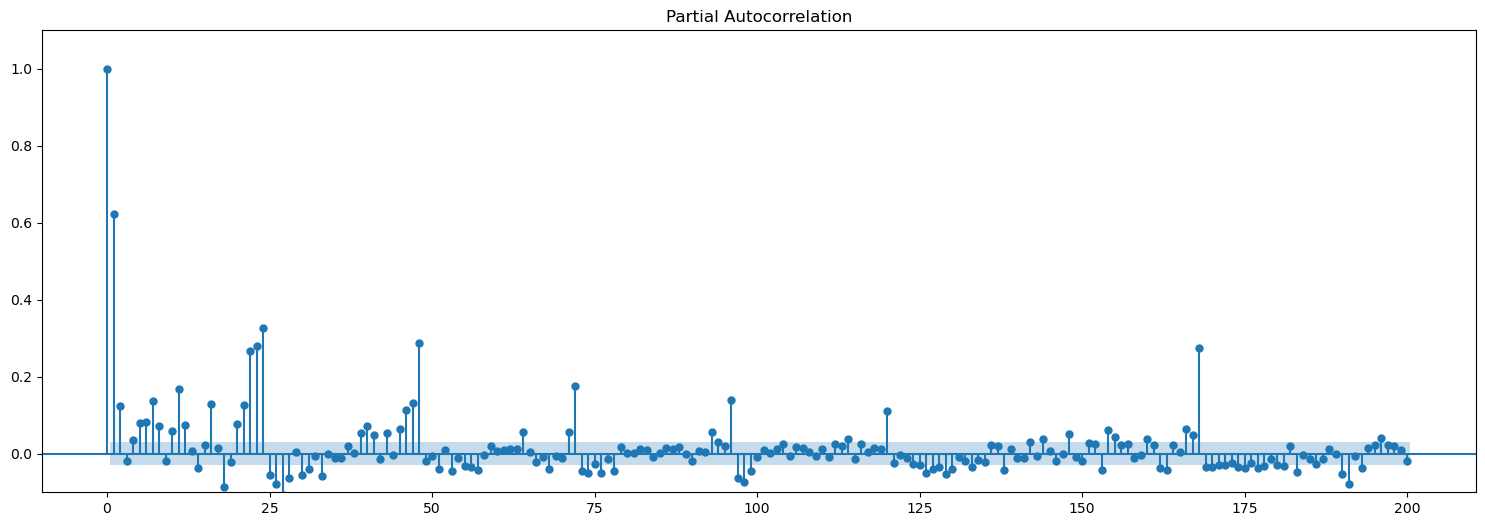

In [21]:
# Автокорреляция частичная

fig = tsaplots.plot_pacf(ts,lags= 200)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()

Что мы можем сказать по графику:
    
- Есть пик на 168 лаге - это недельная сезонность


### 3.3. Декомпозиция ряда

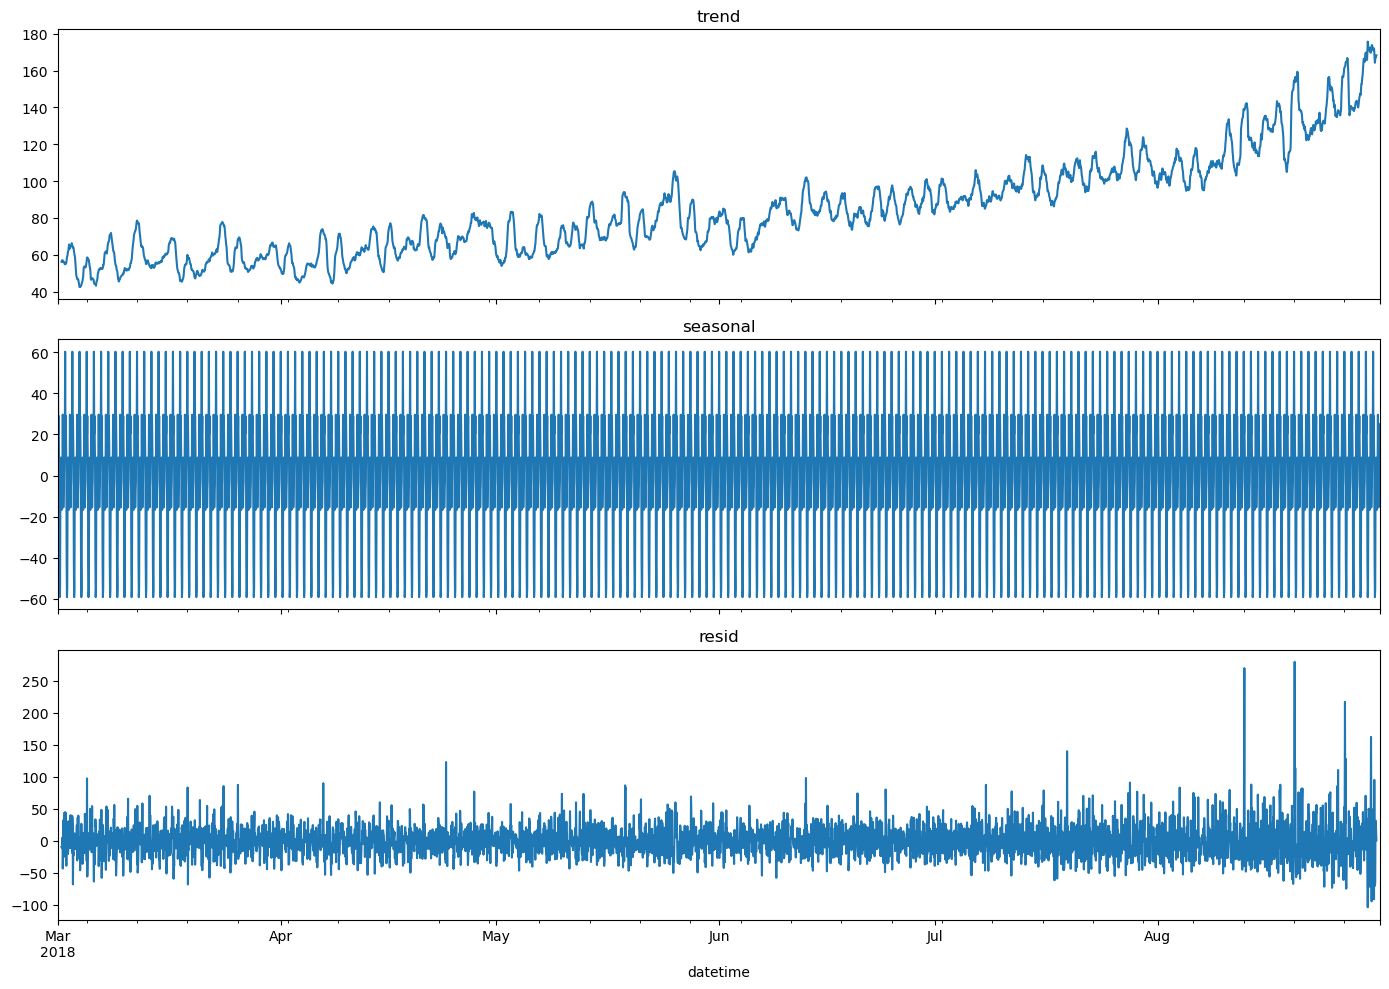

In [22]:
# Графики тренда, сезонности и шума

decomposed = seasonal_decompose(ts, model='additive', period=24)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
decomposed.trend.plot(ax=axes[0], title='trend')
decomposed.seasonal.plot(ax=axes[1], title='seasonal')
decomposed.resid.plot(ax=axes[2], title='resid')
plt.tight_layout()
plt.show()

In [23]:
# Первые значения тренда

print(decomposed.trend.dropna().head(24))

datetime
2018-03-01 12:00:00    56.125000
2018-03-01 13:00:00    56.145833
2018-03-01 14:00:00    56.958333
2018-03-01 15:00:00    57.000000
2018-03-01 16:00:00    56.479167
2018-03-01 17:00:00    56.104167
2018-03-01 18:00:00    56.187500
2018-03-01 19:00:00    56.000000
2018-03-01 20:00:00    56.083333
2018-03-01 21:00:00    55.833333
2018-03-01 22:00:00    55.125000
2018-03-01 23:00:00    54.812500
2018-03-02 00:00:00    54.833333
2018-03-02 01:00:00    55.229167
2018-03-02 02:00:00    55.416667
2018-03-02 03:00:00    55.187500
2018-03-02 04:00:00    55.854167
2018-03-02 05:00:00    57.479167
2018-03-02 06:00:00    58.625000
2018-03-02 07:00:00    59.041667
2018-03-02 08:00:00    59.791667
2018-03-02 09:00:00    61.187500
2018-03-02 10:00:00    62.041667
2018-03-02 11:00:00    62.458333
Freq: h, Name: trend, dtype: float64


Значения тренда в начале периода колеблются в районе 56–57 заказов в час, в начале периода спрос был низок и стабилен. Тренд показывает, что количество заказов стабильно росло на протяжении всего времени.

In [24]:
# Последние значения сезонности

print(decomposed.seasonal.tail(24))

datetime
2018-08-31 00:00:00    60.248112
2018-08-31 01:00:00    20.177074
2018-08-31 02:00:00    28.982743
2018-08-31 03:00:00    17.885407
2018-08-31 04:00:00     2.791145
2018-08-31 05:00:00   -41.563022
2018-08-31 06:00:00   -59.182671
2018-08-31 07:00:00   -55.104461
2018-08-31 08:00:00   -11.212840
2018-08-31 09:00:00     4.443581
2018-08-31 10:00:00     8.759269
2018-08-31 11:00:00    -2.133377
2018-08-31 12:00:00   -16.721606
2018-08-31 13:00:00   -13.352412
2018-08-31 14:00:00    -9.191665
2018-08-31 15:00:00     3.731832
2018-08-31 16:00:00    29.604100
2018-08-31 17:00:00     7.920016
2018-08-31 18:00:00   -15.527958
2018-08-31 19:00:00    -7.124270
2018-08-31 20:00:00    -2.696560
2018-08-31 21:00:00    10.670243
2018-08-31 22:00:00    13.596814
2018-08-31 23:00:00    25.000503
Freq: h, Name: seasonal, dtype: float64


Сезонность показывает отклонения от нормы в зависимости от времени суток.
Значение +25 заказов в 23:00, +60 заказов в 00:00 и -59 в 06:00, -55 в 07:00 говорит о том, что в ночные часы спрос выше ожидаемого по тренду, а днем — ниже.

In [25]:
# Статистика шума

print(decomposed.resid.describe())

count    4392.000000
mean       -0.008130
std        24.696896
min      -103.546496
25%       -14.730950
50%        -1.387969
75%        12.967052
max       279.371423
Name: resid, dtype: float64


Остатки в начале ряда довольно ровные, но ближе к концу становятся более резкими и непредсказуемыми. Это может говорить о том, что в конце периода на заказы стали сильнее влиять какие-то факторы, которые нам не известны.

### 3.4. Создание новых признаков

In [26]:
# Добавим в датасет ключевые лаги

important_lags = [1, 2, 3, 24, 168]

for lag in important_lags:
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)

In [27]:
# Добавим в датасет ключевые скользящие средние

rolling_mean = [24, 168]

for mean in rolling_mean:
    data[f'rolling_mean_{mean}'] = data['num_orders'].shift(1).rolling(window=mean).mean()

In [28]:
# Добавим в датасет день, день недели и час

data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

In [29]:
# Удалим пропуски

data.dropna()

,num_orders,lag_1,lag_2,lag_3,lag_24,lag_168,rolling_mean_24,rolling_mean_168,day,dayofweek,hour
datetime,,,,,,,,,,,
2018-03-08 00:00:00,143,94.0,127.0,108.0,100.0,124.0,60.041667,54.226190,8,3,0
2018-03-08 01:00:00,78,143.0,94.0,127.0,121.0,85.0,61.833333,54.339286,8,3,1
2018-03-08 02:00:00,65,78.0,143.0,94.0,24.0,71.0,60.041667,54.297619,8,3,2
2018-03-08 03:00:00,68,65.0,78.0,143.0,66.0,66.0,61.750000,54.261905,8,3,3
2018-03-08 04:00:00,60,68.0,65.0,78.0,73.0,43.0,61.833333,54.273810,8,3,4
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,207.0,217.0,197.0,72.0,113.0,164.875000,154.297619,31,4,19
2018-08-31 20:00:00,154,136.0,207.0,217.0,142.0,179.0,167.541667,154.434524,31,4,20
2018-08-31 21:00:00,159,154.0,136.0,207.0,198.0,166.0,168.041667,154.285714,31,4,21


### Вывод

- Количество заказов на такси менялось не хаотично, а с определённой регулярностью. Мы видим чёткую суточную и недельную сезонность — например, ночью спрос обычно выше, чем днём.
- В начале периода заказов было стабильно мало, но со временем их стало больше, и этот рост был постепенным и устойчивым — это видно по тренду.
- При этом в конце наблюдений поведение заказов стало менее предсказуемым — появились скачки, которых раньше не было. Это может означать, что на спрос начали влиять какие-то внешние факторы, которые мы не учли


## 3. Обучение

### 3.1. Разделение на тренировочную и тестовую выборки

In [30]:
# Преобразуем цикличные признаки

data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

data['dayofweek_sin'] = np.sin(2 * np.pi * data['dayofweek'] / 7)
data['dayofweek_cos'] = np.cos(2 * np.pi * data['dayofweek'] / 7)

data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)

data.drop(columns=['hour', 'dayofweek', 'day'])

,num_orders,lag_1,lag_2,lag_3,lag_24,lag_168,rolling_mean_24,rolling_mean_168,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,day_sin,day_cos
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.433884,-0.900969,2.012985e-01,0.97953
2018-03-01 01:00:00,85,124.0,NaN,NaN,NaN,NaN,NaN,NaN,0.258819,0.965926,0.433884,-0.900969,2.012985e-01,0.97953
2018-03-01 02:00:00,71,85.0,124.0,NaN,NaN,NaN,NaN,NaN,0.500000,0.866025,0.433884,-0.900969,2.012985e-01,0.97953
2018-03-01 03:00:00,66,71.0,85.0,124.0,NaN,NaN,NaN,NaN,0.707107,0.707107,0.433884,-0.900969,2.012985e-01,0.97953
2018-03-01 04:00:00,43,66.0,71.0,85.0,NaN,NaN,NaN,NaN,0.866025,0.500000,0.433884,-0.900969,2.012985e-01,0.97953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,207.0,217.0,197.0,72.0,113.0,164.875000,154.297619,-0.965926,0.258819,-0.433884,-0.900969,-2.449294e-16,1.00000
2018-08-31 20:00:00,154,136.0,207.0,217.0,142.0,179.0,167.541667,154.434524,-0.866025,0.500000,-0.433884,-0.900969,-2.449294e-16,1.00000
2018-08-31 21:00:00,159,154.0,136.0,207.0,198.0,166.0,168.041667,154.285714,-0.707107,0.707107,-0.433884,-0.900969,-2.449294e-16,1.00000


In [31]:
# Разобьем данные на тренировочную и тестовую выборки

train, test = train_test_split(data, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

### 3.2. Моделирование

pred_previous

In [32]:
# Предскажем следующее значение предыдущим

pred_previous = y_test.shift(1)
pred_previous.iloc[0] = y_train.iloc[-1]

CatBoostRegressor

In [33]:
# Обозначим параметры для перебора Catboost

catboost_params = {
    'model__iterations': [100, 300],
    'model__depth': [3, 5],
    'model__grow_policy': ['Lossguide']
}

In [34]:
# Сделаем пайплайн для Catboost

catboost_pipeline = Pipeline([
    ('model', CatBoostRegressor(verbose=0, random_state=RANDOM_STATE))
])

In [35]:
# GridSearch для Catboost

tscv = TimeSeriesSplit(n_splits=5)

catboost_search = GridSearchCV(
    catboost_pipeline,
    param_grid=catboost_params,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1
)

In [36]:
# Обучим Catboost

catboost_search.fit(X_train, y_train)

,estimator,Pipeline(step...x176609090>)])
,param_grid,"{'model__depth': [3, 5], 'model__grow_policy': ['Lossguide'], 'model__iterations': [100, 300]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


LinearRegression

In [37]:
# Сделаем пайплайн для LinearRegression

linreg_pipeline = Pipeline([
    ('model', LinearRegression())
])

In [38]:
# Обучим LinearRegression

linreg_pipeline.fit(X_train, y_train)

,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


RandomForestRegressor

In [39]:
# Обозначим параметры для перебора RandomForestRegressor

rf_params = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [5, 10]
}

In [40]:
# Сделаем пайплайн для RandomForestRegressor

rf_pipeline = Pipeline([
    ('model', RandomForestRegressor(random_state=RANDOM_STATE))
])

In [41]:
# GridSearch для RandomForestRegressor

rf_search = GridSearchCV(
    rf_pipeline,
    param_grid=rf_params,
    scoring='neg_root_mean_squared_error',
    cv=tscv
)

In [42]:
# Обучим RandomForestRegressor

rf_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [5, 10], 'model__n_estimators': [50, 100]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


In [43]:
# Посчитаем RMSE по кросс-валидации для CatBoost и RandomForest

catboost_cv_score = -catboost_search.best_score_
rf_cv_score = -rf_search.best_score_

print(f"CatBoost CV RMSE: {catboost_cv_score:.2f}")
print(f"RandomForest CV RMSE: {rf_cv_score:.2f}")

CatBoost CV RMSE: 25.02
RandomForest CV RMSE: 23.28


In [44]:
# Посчитаем RMSE по кросс-валидации для LinearRegression

linreg_cv_scores = cross_val_score(
    linreg_pipeline,
    X_train,
    y_train,
    scoring='neg_root_mean_squared_error',
    cv=tscv
)

linreg_cv_score = -np.mean(linreg_cv_scores)
print(f"LinearRegression CV RMSE: {linreg_cv_score:.2f}")

LinearRegression CV RMSE: 23.25


In [45]:
cv_results = {
    'CatBoost': catboost_cv_score,
    'RandomForest': rf_cv_score,
    'LinearRegression': linreg_cv_score
}

best_model_name = min(cv_results, key=cv_results.get)
print(f"Лучшая модель по CV RMSE: {best_model_name}")

Лучшая модель по CV RMSE: LinearRegression


### Вывод

Модели обучены с учётом особенностей временного ряда:
    
- Циклические признаки преобразованы
- Модель предсказания следующего значения предыдущим использована как базовая
- Для трёх моделей (CatBoost, LinearRegression, RandomForest) настроен или проведён перебор параметров
- Лучшую RMSE на кросс-валидации показала LinearRegression - RMSE=23.25

## 4. Тестирование

In [47]:
# Предсказание финальной модели

final_model = {
    'CatBoost': catboost_search.best_estimator_,
    'RandomForest': rf_search.best_estimator_,
    'LinearRegression': linreg_pipeline
}[best_model_name]

y_pred = final_model.predict(X_test)

rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_constant = np.sqrt(mean_squared_error(y_test, pred_previous))

print(f"{best_model_name} Test RMSE: {rmse_model:.2f}")
print(f"Constant Model RMSE: {rmse_constant:.2f}")

LinearRegression Test RMSE: 35.07
Constant Model RMSE: 58.86


### Вывод

Метрики моделей на кросс-валидации:	
    - LinearRegression - лучшая модель: самая точная на кросс-валидации (RMSE = 23.28)
	- RandomForest - тоже хорошо - RMSE = 23.25.
	- CatBoost - работает, но хуже остальных RMSE = 25.02.

Метрики лучшей модели LinearRegression на тестовых данных RMSE=35.07, на константной модели RMSE=58.86

Вывод: LinearRegression справляется лучше всех, его и стоит использовать.

## Общий вывод

Мы успешно подготовили данные, создали информативные признаки и обучили несколько моделей для прогноза количества заказов такси на следующий час.
- Были учтены особенности временного ряда: добавлены лаги, скользящее среднее, преобразованы циклические признаки (день, час, день недели).
- Модель LinearRegression показала наилучшее качество предсказания с RMSE = 35.07 на тестовой выборке, что соответствует поставленной цели — ошибка менее 48.
- Константная модель подтвердила, что продвинутые алгоритмы действительно улучшают качество прогноза.
- Модели RandomForest и CatBoost тоже показали приемлемый результат, но уступили LinearRegression по точности.
